In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython import display as ds
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import math

%matplotlib inline

/home/kvpcloud/.conda/envs/p3_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Dataset:
    main = 'dataset/UCSD_Anomaly_Dataset.v1p2'
    train_images = np.load('{}/train.npy'.format(main))
    train_images_ = np.load('{}/train_.npy'.format(main))
    test_images = np.load('{}/test.npy'.format(main))
    test_images_ = np.load('{}/test_.npy'.format(main))

In [3]:
Dataset.train_images.shape

(200, 158, 238, 3)

In [4]:
Dataset.train_images[0]

array([[[0.36078431, 0.36078431, 0.36078431],
        [0.35686275, 0.35686275, 0.35686275],
        [0.31764706, 0.31764706, 0.31764706],
        ...,
        [0.16470588, 0.16470588, 0.16470588],
        [0.22352941, 0.22352941, 0.22352941],
        [0.29019608, 0.29019608, 0.29019608]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27843137, 0.27843137, 0.27843137],
        ...,
        [0.18823529, 0.18823529, 0.18823529],
        [0.19215686, 0.19215686, 0.19215686],
        [0.33333333, 0.33333333, 0.33333333]],

       [[0.30588235, 0.30588235, 0.30588235],
        [0.32941176, 0.32941176, 0.32941176],
        [0.3372549 , 0.3372549 , 0.3372549 ],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.16862745, 0.16862745, 0.16862745],
        [0.28235294, 0.28235294, 0.28235294]],

       ...,

       [[0.41960784, 0.41960784, 0.41960784],
        [0.41960784, 0.41960784, 0.41960784],
        [0.43137255, 0

In [5]:
class Params:
    latent_feature_count = [10,10,3]
    epochs = 1000 # number of epochs are 1000 now
    reduced_feature_rbf_count = 5 # liklihood fails for 3,4&5 and gets stuck for 2
    frames_for_anomaly = 10

In [6]:
class Network:
    
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.name_scope('Input'):
                self.x = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X')
                self.x_ = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X_')

        self.encoder, self.decoder = self.build_network(self.x)

    def build_network(self, x):
        def encoder(x):
            with self.graph.as_default():
                with tf.name_scope('Encoder'):
                    x = tf.layers.conv2d(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1), )
                    print('After 1st Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 2nd Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    encoded = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 3rd Pooling (Final Encoded)', x.get_shape())
                    tf.summary.image('encoder_hidden_final', encoded[:,:,:,0:3], max_outputs=1)
                    
                    with tf.name_scope('Latent'):
                    
                        self.latent = tf.layers.dense(tf.contrib.layers.flatten(encoded), #depricated
                                                  units=np.prod(Params.latent_feature_count), 
                                                  activation=tf.nn.relu)

                        print('Latent', self.latent.get_shape())
                        tf.summary.histogram('Latent', self.latent)

                
            return encoded

        def decoder(encoded):
            with self.graph.as_default():
                with tf.name_scope('Decoder'):
                    #x = tf.reshape(encoded, [-1] + Params.latent_feature_count)
                    x = encoded
                    x = tf.layers.conv2d_transpose(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 4th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_4', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 5th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_5', x[:,:,:,0:3],max_outputs=1)
                    
                    decoded = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.sigmoid)
                    print('After 6th conv transpose (final decoded)', decoded.get_shape())
                    tf.summary.image('decoder_hidden_decoded', decoded[:,:,:,0:3],max_outputs=1)

            return decoded
        
        return encoder, decoder
    
    def get_encoded(self):
        with self.graph.as_default():
            encoded = self.encoder(self.x_)

        return encoded
    
    def get_decoded(self):
        encoded = self.get_encoded()
        x_hat = self.decoder(encoded)
        return x_hat
    
    def lstm(self, latent):
        with self.graph.as_default():

            with tf.name_scope('LSTM') as lstm_scope:
                #x = tf.layers.dense(latent, units=np.prod(Params.latent_feature_count), activation=tf.nn.relu)

                x = latent

                lstm = tf.contrib.rnn.BasicLSTMCell(64)

                # Grouping 10 images into 1 to form a video clip for which Anomaly detection will be done
                x_list = tf.split(x, 10, axis=0) 

                y_list, self.state = tf.nn.static_rnn(lstm, x_list, dtype = tf.float32)

                lstm_out = tf.stack(y_list[-1]) # we only need the last output
                lstm_out = tf.layers.dense(lstm_out, Params.reduced_feature_rbf_count)
                print('Reduced dimensions for RBF', lstm_out.get_shape())
                lstm_out = tf.print(lstm_out, [lstm_out], "********* Output of LSTM, Input to RBF ")

        return lstm_out

    def rbf(self, lstm_output):
        with self.graph.as_default():
            def get_cost(U, Z, Q): 

                cost = - (-U - tf.log(Z)) 
                return tf.reduce_mean(cost)

            f = Params.reduced_feature_rbf_count #np.prod(Params.latent_feature_count)


            with tf.name_scope('RBF'):
                X = lstm_output

                mu = tf.Variable(tf.random_uniform([1,f], minval=0.1, dtype=tf.float32))
                #Q_ = tf.Variable(tf.truncated_normal([f], mean = 1)) 
                global_step = tf.Variable(0, trainable=False)

                sd = tf.Variable(tf.random_uniform([f], minval=0.1, dtype=tf.float32))

                sigma = sd #tf.square(sd)
                sigma = tf.print(sigma, [sigma], "************ Sigma ")
                sigma_inverse = tf.reciprocal(sigma)
                sigma_inverse = tf.print(sigma_inverse, [sigma_inverse], '************* sigma_inverse')

                cov_inverse = tf.diag(sigma_inverse)

                det_sigma = tf.reduce_prod(sigma) #tf.pow(sigma, 0.5))
                det_sigma = tf.print(det_sigma, [det_sigma], '****** Determinant')
                
                z = tf.multiply(2*math.pi, det_sigma)
                z = tf.print(z, [z], ' ******* z')

                with tf.name_scope('Likelihood'):

                    M = X - mu

                    energy = tf.matmul(tf.matmul(M,cov_inverse), tf.transpose(M)) 
                    print("Energy after matmul", energy.get_shape())
                    energy = tf.print(energy, [energy], '*********** Energy after matmul')

                    energy = tf.reduce_sum(energy, axis = 1, keepdims = True)
                    energy = tf.print(energy, [energy], '*********** Energy after summation')
                    print('Energy after summation', energy.get_shape())

                    print('X', X.get_shape())
                    print('cov_inverse', cov_inverse.get_shape())

                    expnt = tf.exp(-tf.multiply(energy, 0.5))
                    print('exponent', expnt.get_shape())
                    expnt = tf.print(expnt, [expnt], "********* Exponent")

                    Y_ = tf.divide(expnt, z)


                    #Y_ = tf.layers.dense(Y_, 1)
                    rbf_out = Y_ #tf.reduce_mean(Y_) # tf.layers.dense(Y_, 1)
                    Y_ = tf.print(Y_, [Y_], 'XXXXXXXXXXXXXXXXXXXX Y_ XXXXXXXXXXXXXXXXXXXXXXXXXXXX')
                    print('Y_', Y_.get_shape())

                with tf.name_scope('Loss'):
                    #cost = -1 * tf.log(Y_ + 0.0001) # Adding a small delta because log is not a continuous function. 
                    cost = energy + tf.log(z)
                    cost = tf.print(cost,[cost], "******** Cost")
                    loss = tf.reduce_mean(cost) #get_cost(U, Z, Q) # 1- Y_[0]
                    loss = tf.print(loss, [loss], "**************** Loss")
                    tf.summary.scalar('loss', loss)

        return mu, sd, rbf_out, loss

    def get_spatial_loss(self):
        
        with self.graph.as_default():
            
            self.x_hat = self.get_decoded()
            spatial_loss = tf.losses.mean_squared_error(labels=self.x_, predictions=self.x_hat)
                
        return spatial_loss
    
    def get_temporal_loss(self):
        
        with self.graph.as_default():
            with tf.name_scope('Temporal_Autoencoder'):
                
                lstm_out = self.lstm(self.latent)
                print("LSTM: Images will be grouped (e.g. 10 images to 1 clip) into video clips when fed to LSTM",
                      lstm_out.get_shape())
                tf.summary.histogram("LSTM", lstm_out)

                self.mean, self.sigma, self.likelihood, likelihood_loss = self.rbf(lstm_out)
                print("Likelihood: ", self.likelihood.get_shape())
                tf.summary.scalar("Temporal_Loss", likelihood_loss)
                
        return likelihood_loss
    
    
    def get_optimizer_loss(self):
        
        with self.graph.as_default():
            self.x_hat = self.get_decoded()

            with tf.name_scope('Optimization'):
                
                spatial_loss = self.get_spatial_loss()
                temporal_loss = self.get_temporal_loss()
                
                loss = spatial_loss + temporal_loss
                tf.summary.scalar("loss",loss)
                
                starter_learning_rate = 0.001
                global_step = tf.Variable(0, trainable=False)
                #global_step = tf.print(global_step, [global_step], "########## Global Step Completed #############")
                learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   int(Params.epochs / 3), 0.5, staircase=True)
                train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
                tf.summary.scalar("learning_rate",learning_rate)

            merged = tf.summary.merge_all()
        return train, merged, loss, self.likelihood, self.mean, self.sigma
        
        

In [7]:
loss_arr=[]
likelihood_arr=[]
network = Network()

m_b_s = 3*Params.frames_for_anomaly
with tf.Session(graph=network.graph) as sess:

    
    optim_loss = network.get_optimizer_loss()
    
    train_writer = tf.summary.FileWriter('logdir/cae_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(Params.epochs):
        m_b_s_old = 0
        for m_b_s_new in range(m_b_s, Dataset.train_images_.shape[0], m_b_s  ):
            _, merged, loss, likelihood, mean, sigma = sess.run(optim_loss, 
                                                   feed_dict={network.x:Dataset.train_images_[m_b_s_old:m_b_s_new,...],
                                                            network.x_: Dataset.train_images[m_b_s_old:m_b_s_new,...]})

            m_b_s_old = m_b_s_new

        if epoch % 1 == 0:
            print('epoch:', epoch, 'loss:', loss, 'Likelihood:', np.asarray(likelihood).flatten(), 'Mean:', np.asarray(mean).flatten())
            train_writer.add_summary(merged, epoch)
            loss_arr.append(loss)
            likelihood_arr.append(np.mean(likelihood))
        
    
    #Dataset.latent = sess.run(network.latent,feed_dict={network.x:Dataset.train_images_,
    #                                        network.x_: Dataset.train_images})
    
    
    print('Getting predictions for Training Data')
    Dataset.reproduced_images_training = sess.run(network.x_hat,feed_dict={network.x:Dataset.train_images_[:30,... ],
                                            network.x_: Dataset.train_images[:30,... ]})
    Dataset.likelihood_training, Dataset.mean_training, Dataset.sigma_training = sess.run([network.likelihood, network.mean, network.sigma],
                                                                                          feed_dict={network.x:Dataset.train_images_[:30,... ],
                                                                                        network.x_: Dataset.train_images[:30,... ]})
    
    print('Getting predictions for Testing Data')
    Dataset.reproduced_images = sess.run(network.x_hat,feed_dict={network.x:Dataset.test_images_[:30,... ],
                                            network.x_: Dataset.test_images[:30,... ]})
    Dataset.likelihood, Dataset.mean, Dataset.sigma = sess.run([network.likelihood, network.mean, network.sigma],
                                                               feed_dict={network.x:Dataset.test_images_[:30,... ],
                                                                network.x_: Dataset.test_images[:30,... ]})
    
    

After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (?, 158, 238, 3)
After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (

epoch: 53 loss: -8.437266 Likelihood: [10881.21 10881.21 10881.21] Mean: [0.9385288  0.58291614 0.33689982 0.7626341  0.8045188 ]
epoch: 54 loss: -8.992419 Likelihood: [15311.956 15311.956 15311.956] Mean: [0.9394999  0.58291614 0.33689982 0.76241034 0.8045188 ]
epoch: 55 loss: -9.38184 Likelihood: [19726.715 19726.715 19726.715] Mean: [0.94021183 0.58291614 0.33689982 0.7622553  0.8045188 ]
epoch: 56 loss: -9.587408 Likelihood: [22712.752 22712.752 22712.752] Mean: [0.9405859  0.58291614 0.33689982 0.7621793  0.8045188 ]
epoch: 57 loss: -9.777531 Likelihood: [26011.822 26011.822 26011.822] Mean: [0.9409249  0.58291614 0.33689982 0.76211435 0.8045188 ]
epoch: 58 loss: -9.957469 Likelihood: [29712.568 29712.568 29712.568] Mean: [0.9412375  0.58291614 0.33689982 0.7620574  0.8045188 ]
epoch: 59 loss: -10.130885 Likelihood: [33922.832 33922.832 33922.832] Mean: [0.9415289  0.58291614 0.33689982 0.7620067  0.8045188 ]
epoch: 60 loss: -10.300702 Likelihood: [38783.363 38783.363 38783.363] M

epoch: 115 loss: nan Likelihood: [-85151656. -85151656. -85151656.] Mean: [0.9458659  0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 116 loss: nan Likelihood: [-1.0314968e+08 -1.0314968e+08 -1.0314968e+08] Mean: [0.94586843 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 117 loss: nan Likelihood: [-1.3467666e+08 -1.3467666e+08 -1.3467666e+08] Mean: [0.94587094 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 118 loss: nan Likelihood: [-2.1035309e+08 -2.1035309e+08 -2.1035309e+08] Mean: [0.9458732  0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 119 loss: nan Likelihood: [-1.02900954e+09 -1.02900954e+09 -1.02900954e+09] Mean: [0.94587535 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 120 loss: nan Likelihood: [-2.5989163e+08 -2.5989163e+08 -2.5989163e+08] Mean: [0.9458775  0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 121 loss: nan Likelihood: [-1.7902011e+08 -1.7902011e+08 -1.7902011e+08] Mean: [0.94587964 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 1

epoch: 173 loss: nan Likelihood: [-4.7237624e+10 -4.7237624e+10 -4.7237624e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 174 loss: nan Likelihood: [-7.341022e+10 -7.341022e+10 -7.341022e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 175 loss: -24.837502 Likelihood: [6.145835e+10 6.145835e+10 6.145835e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 176 loss: -23.808577 Likelihood: [2.1964489e+10 2.1964489e+10 2.1964489e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 177 loss: -23.59889 Likelihood: [1.7809596e+10 1.7809596e+10 1.7809596e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 178 loss: -23.582571 Likelihood: [1.7521244e+10 1.7521244e+10 1.7521244e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 179 loss: -23.654848 Likelihood: [1.8834405e+10 1.8834405e+10 1.8834405e+10] Mean: [0.94591737 0.58291614 0.33689928 0.7615096

epoch: 230 loss: -26.83813 Likelihood: [4.5429673e+11 4.5429673e+11 4.5429673e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 231 loss: -28.080755 Likelihood: [1.5739963e+12 1.5739963e+12 1.5739963e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 232 loss: nan Likelihood: [-4.6089575e+11 -4.6089575e+11 -4.6089575e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 233 loss: nan Likelihood: [-8.285508e+11 -8.285508e+11 -8.285508e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 234 loss: -26.882055 Likelihood: [4.7469137e+11 4.7469137e+11 4.7469137e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 235 loss: nan Likelihood: [-1.3044185e+12 -1.3044185e+12 -1.3044185e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 236 loss: -26.315935 Likelihood: [2.6949291e+11 2.6949291e+11 2.6949291e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096 

epoch: 288 loss: nan Likelihood: [-1.5201719e+11 -1.5201719e+11 -1.5201719e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 289 loss: nan Likelihood: [-1.6051092e+11 -1.6051092e+11 -1.6051092e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 290 loss: nan Likelihood: [-1.7006846e+11 -1.7006846e+11 -1.7006846e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 291 loss: nan Likelihood: [-1.8091198e+11 -1.8091198e+11 -1.8091198e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 292 loss: nan Likelihood: [-1.9333272e+11 -1.9333272e+11 -1.9333272e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 293 loss: nan Likelihood: [-2.07721e+11 -2.07721e+11 -2.07721e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 294 loss: nan Likelihood: [-2.2461386e+11 -2.2461386e+11 -2.2461386e+11] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch

epoch: 346 loss: -30.285038 Likelihood: [1.4263636e+13 1.4263636e+13 1.4263636e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 347 loss: nan Likelihood: [-3.651183e+13 -3.651183e+13 -3.651183e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 348 loss: nan Likelihood: [-1.1089372e+13 -1.1089372e+13 -1.1089372e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 349 loss: nan Likelihood: [-1.740338e+13 -1.740338e+13 -1.740338e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 350 loss: nan Likelihood: [-1.7953002e+14 -1.7953002e+14 -1.7953002e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 351 loss: nan Likelihood: [-4.1587215e+15 -4.1587215e+15 -4.1587215e+15] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 352 loss: nan Likelihood: [-4.8696666e+12 -4.8696666e+12 -4.8696666e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
e

epoch: 403 loss: -27.711235 Likelihood: [1.0874943e+12 1.0874943e+12 1.0874943e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 404 loss: -27.734598 Likelihood: [1.1132028e+12 1.1132028e+12 1.1132028e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 405 loss: -27.758852 Likelihood: [1.1405307e+12 1.1405307e+12 1.1405307e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 406 loss: -27.78407 Likelihood: [1.1696535e+12 1.1696535e+12 1.1696535e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 407 loss: -27.810328 Likelihood: [1.2007743e+12 1.2007743e+12 1.2007743e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 408 loss: -27.837727 Likelihood: [1.234129e+12 1.234129e+12 1.234129e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 409 loss: -27.866375 Likelihood: [1.2699958e+12 1.2699958e+12 1.2699958e+12] Mean: [0.94591737 0.58291614 0.3368992

epoch: 460 loss: nan Likelihood: [-2.355794e+13 -2.355794e+13 -2.355794e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 461 loss: nan Likelihood: [-3.9187487e+13 -3.9187487e+13 -3.9187487e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 462 loss: -32.759098 Likelihood: [1.6930783e+14 1.6930783e+14 1.6930783e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 463 loss: -32.607933 Likelihood: [1.4555523e+14 1.4555523e+14 1.4555523e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 464 loss: nan Likelihood: [-9.15184e+12 -9.15184e+12 -9.15184e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 465 loss: nan Likelihood: [-5.749524e+12 -5.749524e+12 -5.749524e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 466 loss: nan Likelihood: [-4.951736e+12 -4.951736e+12 -4.951736e+12] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch:

epoch: 518 loss: -30.607197 Likelihood: [1.9684026e+13 1.9684026e+13 1.9684026e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 519 loss: -30.36499 Likelihood: [1.5449901e+13 1.5449901e+13 1.5449901e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 520 loss: -30.293646 Likelihood: [1.4386029e+13 1.4386029e+13 1.4386029e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 521 loss: -30.291904 Likelihood: [1.4360993e+13 1.4360993e+13 1.4360993e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 522 loss: -30.326155 Likelihood: [1.4861394e+13 1.4861394e+13 1.4861394e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 523 loss: -30.383139 Likelihood: [1.5732837e+13 1.5732837e+13 1.5732837e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 524 loss: -30.45815 Likelihood: [1.6958371e+13 1.6958371e+13 1.6958371e+13] Mean: [0.94591737 0.58291614 0.33689

epoch: 576 loss: nan Likelihood: [-2.2511431e+13 -2.2511431e+13 -2.2511431e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 577 loss: nan Likelihood: [-2.350624e+13 -2.350624e+13 -2.350624e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 578 loss: nan Likelihood: [-2.4635123e+13 -2.4635123e+13 -2.4635123e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 579 loss: nan Likelihood: [-2.593056e+13 -2.593056e+13 -2.593056e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 580 loss: nan Likelihood: [-2.743709e+13 -2.743709e+13 -2.743709e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 581 loss: nan Likelihood: [-2.9217618e+13 -2.9217618e+13 -2.9217618e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 582 loss: nan Likelihood: [-3.1364343e+13 -3.1364343e+13 -3.1364343e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 5

epoch: 633 loss: nan Likelihood: [-4.1046386e+13 -4.1046386e+13 -4.1046386e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 634 loss: nan Likelihood: [-3.978781e+13 -3.978781e+13 -3.978781e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 635 loss: nan Likelihood: [-3.941747e+13 -3.941747e+13 -3.941747e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 636 loss: nan Likelihood: [-3.949033e+13 -3.949033e+13 -3.949033e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 637 loss: nan Likelihood: [-3.9800912e+13 -3.9800912e+13 -3.9800912e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 638 loss: nan Likelihood: [-4.0247803e+13 -4.0247803e+13 -4.0247803e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 639 loss: nan Likelihood: [-4.077945e+13 -4.077945e+13 -4.077945e+13] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 640 

epoch: 691 loss: -33.15925 Likelihood: [2.5261147e+14 2.5261147e+14 2.5261147e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 692 loss: -33.399628 Likelihood: [3.2125325e+14 3.2125325e+14 3.2125325e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 693 loss: -33.825737 Likelihood: [4.9193223e+14 4.9193223e+14 4.9193223e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 694 loss: -35.49761 Likelihood: [2.6181205e+15 2.6181205e+15 2.6181205e+15] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 695 loss: -33.10083 Likelihood: [2.3827651e+14 2.3827651e+14 2.3827651e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 696 loss: -32.489624 Likelihood: [1.2931201e+14 1.2931201e+14 1.2931201e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 697 loss: -32.287952 Likelihood: [1.0569471e+14 1.0569471e+14 1.0569471e+14] Mean: [0.94591737 0.58291614 0.336899

epoch: 748 loss: nan Likelihood: [-1.7396783e+14 -1.7396783e+14 -1.7396783e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 749 loss: nan Likelihood: [-1.6104856e+14 -1.6104856e+14 -1.6104856e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 750 loss: nan Likelihood: [-1.559405e+14 -1.559405e+14 -1.559405e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 751 loss: nan Likelihood: [-1.5431994e+14 -1.5431994e+14 -1.5431994e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 752 loss: nan Likelihood: [-1.5443387e+14 -1.5443387e+14 -1.5443387e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 753 loss: nan Likelihood: [-1.5547307e+14 -1.5547307e+14 -1.5547307e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 754 loss: nan Likelihood: [-1.5703818e+14 -1.5703818e+14 -1.5703818e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
ep

epoch: 806 loss: nan Likelihood: [-1.853285e+15 -1.853285e+15 -1.853285e+15] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 807 loss: nan Likelihood: [-1.3598947e+16 -1.3598947e+16 -1.3598947e+16] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 808 loss: -35.975555 Likelihood: [4.2223764e+15 4.2223764e+15 4.2223764e+15] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 809 loss: nan Likelihood: [-5.7067107e+15 -5.7067107e+15 -5.7067107e+15] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 810 loss: -34.874065 Likelihood: [1.4034138e+15 1.4034138e+15 1.4034138e+15] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 811 loss: -33.77861 Likelihood: [4.6928504e+14 4.6928504e+14 4.6928504e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 812 loss: -33.47721 Likelihood: [3.4716774e+14 3.4716774e+14 3.4716774e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  

epoch: 863 loss: -33.299877 Likelihood: [2.90754e+14 2.90754e+14 2.90754e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 864 loss: -33.30126 Likelihood: [2.911562e+14 2.911562e+14 2.911562e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 865 loss: -33.30265 Likelihood: [2.915609e+14 2.915609e+14 2.915609e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 866 loss: -33.304047 Likelihood: [2.919683e+14 2.919683e+14 2.919683e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 867 loss: -33.30545 Likelihood: [2.9237822e+14 2.9237822e+14 2.9237822e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 868 loss: -33.306858 Likelihood: [2.927908e+14 2.927908e+14 2.927908e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 869 loss: -33.308277 Likelihood: [2.9320604e+14 2.9320604e+14 2.9320604e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.80

epoch: 920 loss: -33.36277 Likelihood: [3.0962715e+14 3.0962715e+14 3.0962715e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 921 loss: -33.363667 Likelihood: [3.0990528e+14 3.0990528e+14 3.0990528e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 922 loss: -33.36457 Likelihood: [3.1018482e+14 3.1018482e+14 3.1018482e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 923 loss: -33.365475 Likelihood: [3.104658e+14 3.104658e+14 3.104658e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 924 loss: -33.366383 Likelihood: [3.107482e+14 3.107482e+14 3.107482e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 925 loss: -33.3673 Likelihood: [3.1103214e+14 3.1103214e+14 3.1103214e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 926 loss: -33.368214 Likelihood: [3.1131755e+14 3.1131755e+14 3.1131755e+14] Mean: [0.94591737 0.58291614 0.33689928 0.76

epoch: 977 loss: -33.40222 Likelihood: [3.220869e+14 3.220869e+14 3.220869e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 978 loss: -33.402786 Likelihood: [3.2226858e+14 3.2226858e+14 3.2226858e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 979 loss: -33.40335 Likelihood: [3.2245108e+14 3.2245108e+14 3.2245108e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 980 loss: -33.40392 Likelihood: [3.226344e+14 3.226344e+14 3.226344e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 981 loss: -33.40449 Likelihood: [3.2281847e+14 3.2281847e+14 3.2281847e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 982 loss: -33.405064 Likelihood: [3.2300342e+14 3.2300342e+14 3.2300342e+14] Mean: [0.94591737 0.58291614 0.33689928 0.7615096  0.8045188 ]
epoch: 983 loss: -33.40564 Likelihood: [3.2318907e+14 3.2318907e+14 3.2318907e+14] Mean: [0.94591737 0.58291614 0.33689928 0.761

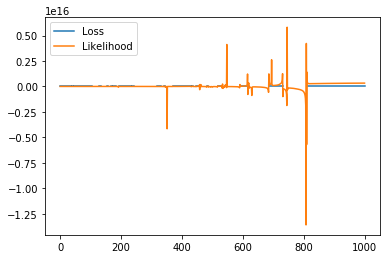

In [8]:
plt.plot(loss_arr, label='Loss')
plt.plot(likelihood_arr, label='Likelihood')
plt.legend()

In [9]:
#np.save('{}/latent_train'.format(Dataset.main),Dataset.latent)

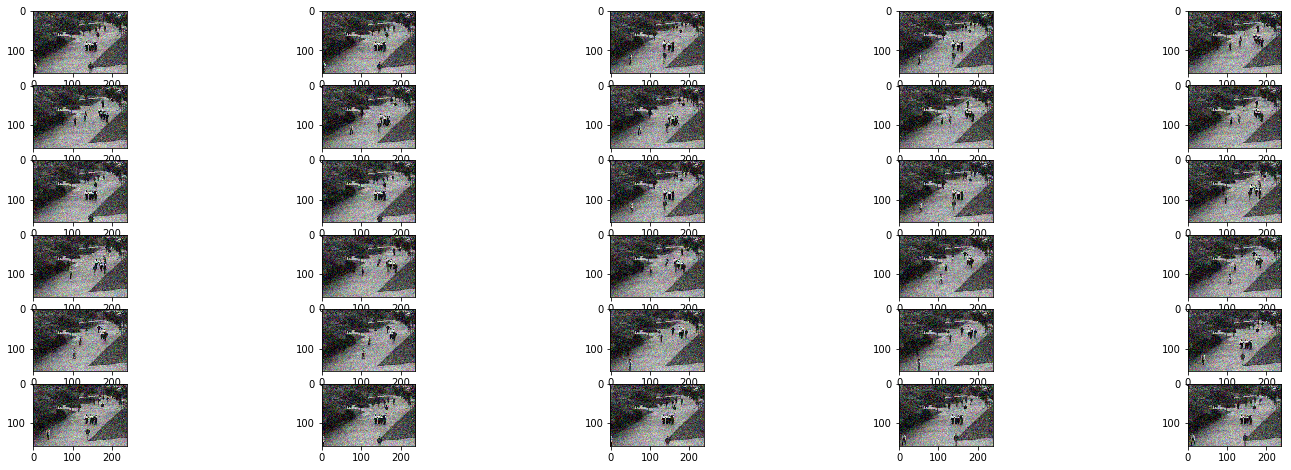

In [10]:
fig, axs = plt.subplots(6,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.test_images_[:30]):
    axs[i].imshow(imgs[:,:,:])

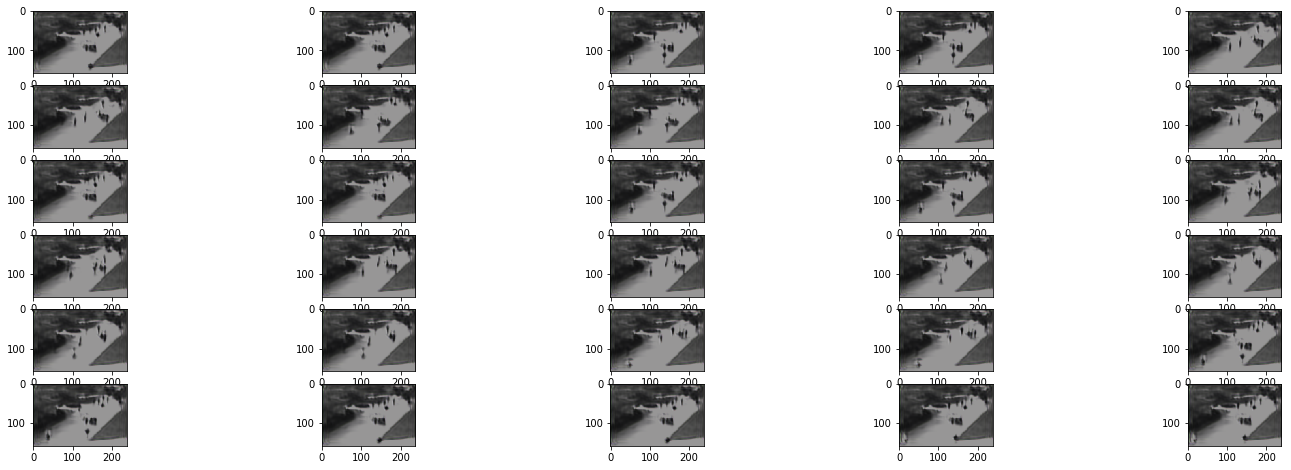

In [11]:
fig, axs = plt.subplots(6,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.reproduced_images[:30]):
    axs[i].imshow(imgs[:,:,:])

In [12]:
Dataset.likelihood, Dataset.mean, Dataset.sigma

(array([[3.2620827e+14],
        [3.2620827e+14],
        [3.2620827e+14]], dtype=float32),
 array([[0.94591737, 0.58291614, 0.33689928, 0.7615096 , 0.8045188 ]],
       dtype=float32),
 array([2.2975743e-02, 1.6478475e-06, 5.1972410e-03, 1.4293718e-02,
        1.7346845e-04], dtype=float32))

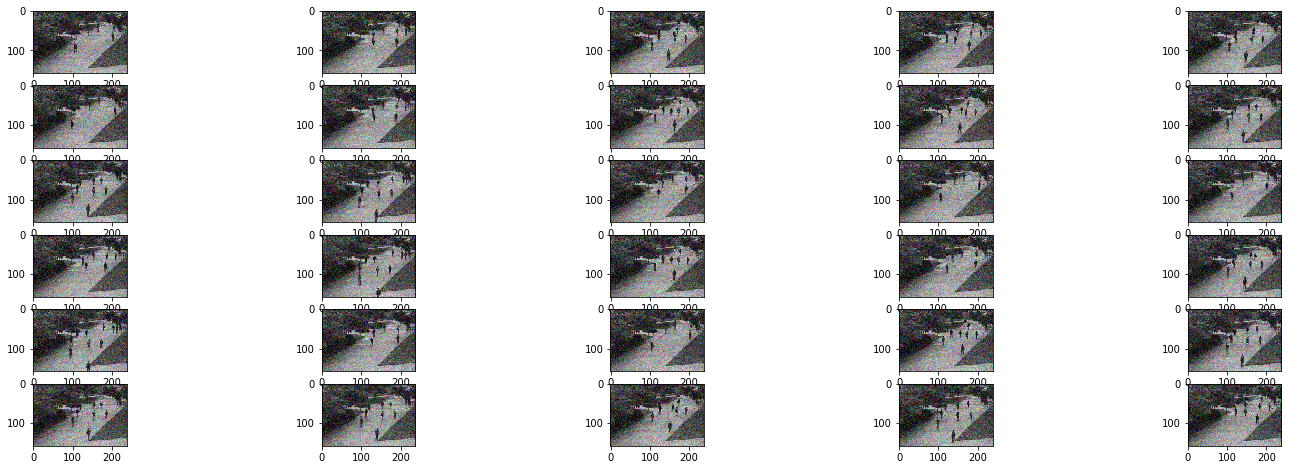

In [13]:
fig, axs = plt.subplots(6,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.train_images_[:30]):
    axs[i].imshow(imgs[:,:,:])

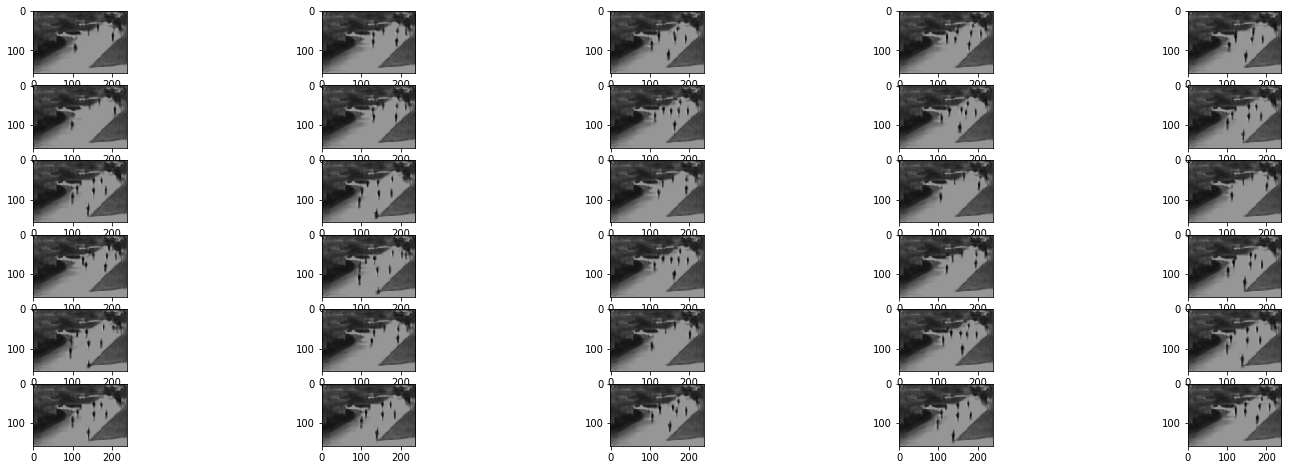

In [14]:
fig, axs = plt.subplots(6,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.reproduced_images_training[:30]):
    axs[i].imshow(imgs[:,:,:])

In [15]:
Dataset.likelihood_training, Dataset.mean_training, Dataset.sigma_training

(array([[3.2620827e+14],
        [3.2620827e+14],
        [3.2620827e+14]], dtype=float32),
 array([[0.94591737, 0.58291614, 0.33689928, 0.7615096 , 0.8045188 ]],
       dtype=float32),
 array([2.2975743e-02, 1.6478475e-06, 5.1972410e-03, 1.4293718e-02,
        1.7346845e-04], dtype=float32))